# Synthetic Data Tutorial

This notebook shows how to process MTH5 data from a synthetic dataset.

It also shows how to modify processing so that Fourier coefficients are saved in the mth5.  These FCs can be used to perform TF estimation using different regression settings.  The same FCs will be used for feature extraction in future (This section is a work in Progress). 

## Contents:

1. [Process Synthetic Data with Aurora](#Process-Synthetic-Data-with-Aurora)
2. [Fourier coefficient storage in MTH5](#Fourier-coefficient-storage-in-MTH5)

## Process Synthetic Data with Aurora

Here is a minimal example of running aurora processing on an mth5 populated with synthetic time series.


Steps:
1. Create the synthetic mth5
2. Get a Run Summary from the mth5
3. Select the station to process and optionally the remote reference station
4. Create a processing config
5. Generate TFs
6. Archive the TFs (in emtf_xml or z-file)

### Here are the modules we will need to import 

In [1]:
import pathlib
import warnings

from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from mth5.data.make_mth5_from_asc import create_test12rr_h5
from mth5.data.paths import SyntheticTestPaths
from mtpy.processing import RunSummary, KernelDataset

warnings.filterwarnings('ignore')

### Define target folder and mth5 path

By default, the synthetic mth5 file is used for testing in `aurora/tests/synthetic/` and probably already exists on your system if you have run the tests. In the code below, we check if the file exists already, and if not we make it.

**NOTE:** If using a read-only HPC installation, you may not be able to write to the directory where aurora is installed.  In that case, defining your target path as somewhere you have write permission.  In that case, uncommment the READ ONLY INSTALLATION block below.

In [2]:
synthetic_test_paths = SyntheticTestPaths()
target_folder = synthetic_test_paths.mth5_path

## READ ONLY INSTALLATION
# home = pathlib.Path.home()
# target_folder = home.joinpath("aurora_test_folder")
# target_folder.mkdir(parents=True, exist_ok=True)

mth5_path = target_folder.joinpath("test12rr.h5")

If the mth5 doesn't already exist, or you want to re-make it, call `create_test12rr_h5()`

In [3]:
# Uncomment this to start with a fresh mth5 file

# mth5_path.unlink()

In [4]:
if not mth5_path.exists():
    create_test12rr_h5(target_folder=target_folder)   

### Get a Run Summary

Note that we didn't need to explicitly open the mth5 to do that, we can pass the path if we want.
Run summary takes a list of mth5 paths as input argument.

In [5]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([mth5_path,])
run_summary = mth5_run_summary.clone()
run_summary.mini_summary

24:10:14T13:36:54 | INFO | line:777 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/software/irismt/mth5/mth5/data/mth5/test12rr.h5


,survey,station,run,start,end,duration
0,EMTF Synthetic,test1,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0
1,EMTF Synthetic,test2,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0


### Define a Kernel Dataset


In [6]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "test1", "test2")
kernel_dataset.mini_summary

24:10:14T13:36:54 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column fc, adding and setting dtype to <class 'pandas._libs.missing.NAType'>.
24:10:14T13:36:54 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column remote, adding and setting dtype to <class 'bool'>.
24:10:14T13:36:54 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column run_dataarray, adding and setting dtype to <class 'NoneType'>.
24:10:14T13:36:54 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column stft, adding and setting dtype to <class 'NoneType'>.
24:10:14T13:36:54 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column mth5_obj, adding and setting dtype to <class 'NoneType'>.


,survey,station,run,start,end,duration
0,EMTF Synthetic,test1,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0
1,EMTF Synthetic,test2,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0


### Now define the processing Configuration

The only things we need to provide are our band processing scheme, and the data sample rate to generate a default processing configuration.

The config will get its information about the specific stations to process via the kernel dataset.

**NOTE:** When doing only single station processing you need to specify RME processing (rather than remote reference processing which expects extra time series from another station)

In [7]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset)

# you can export the config to a json by uncommenting the following line
# cfg_json = config.to_json()

24:10:14T13:36:54 | INFO | line:108 |aurora.config.config_creator | determine_band_specification_style | Bands not defined; setting to EMTF BANDS_DEFAULT_FILE


### Take a look at the processing configuration

In [8]:
config

{
    "processing": {
        "band_setup_file": "/home/kkappler/software/irismt/aurora/aurora/config/emtf_band_setup/bs_test.cfg",
        "band_specification_style": "EMTF",
        "channel_nomenclature.ex": "ex",
        "channel_nomenclature.ey": "ey",
        "channel_nomenclature.hx": "hx",
        "channel_nomenclature.hy": "hy",
        "channel_nomenclature.hz": "hz",
        "decimations": [
            {
                "decimation_level": {
                    "anti_alias_filter": "default",
                    "bands": [
                        {
                            "band": {
                                "center_averaging_type": "geometric",
                                "closed": "left",
                                "decimation_level": 0,
                                "frequency_max": 0.23828125,
                                "frequency_min": 0.19140625,
                                "index_max": 30,
                                "index_min": 25
 

### Call process_mth5

24:10:14T13:36:54 | INFO | line:277 |aurora.pipelines.transfer_function_kernel | show_processing_summary | Processing Summary Dataframe:
24:10:14T13:36:55 | INFO | line:278 |aurora.pipelines.transfer_function_kernel | show_processing_summary | 
   duration  has_data  n_samples  run station          survey       run_hdf5_reference   station_hdf5_reference    fc  remote  stft mth5_obj dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0   39999.0      True      40000  001   test1  EMTF Synthetic  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         0         1.0     1.000000            128.0                 128      39999.0             416.0
1   39999.0      True      40000  001   test1  EMTF Synthetic  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         1         4.0     0.250000            512.0                 128       9999.0             103.0
2   39999.0      True  

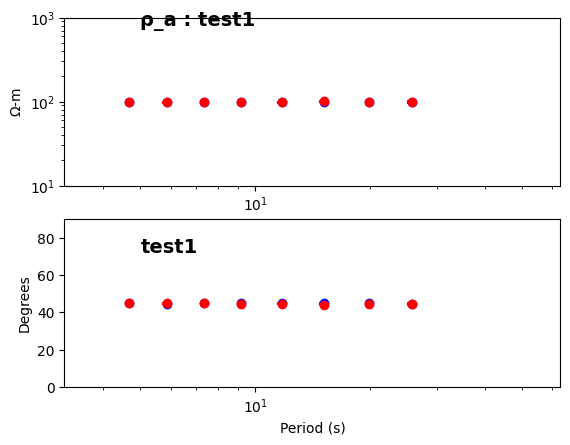

24:10:14T13:36:57 | INFO | line:124 |aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 1
24:10:14T13:36:57 | INFO | line:134 |aurora.pipelines.transfer_function_kernel | update_dataset_df | FC already exists for survey: EMTF Synthetic, station: test1, run: 001 -- skipping decimation
24:10:14T13:36:57 | INFO | line:134 |aurora.pipelines.transfer_function_kernel | update_dataset_df | FC already exists for survey: EMTF Synthetic, station: test2, run: 001 -- skipping decimation
24:10:14T13:36:57 | INFO | line:143 |aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 1 Successfully
24:10:14T13:36:57 | INFO | line:35 |aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Processing band 102.915872s  (0.009717Hz)
24:10:14T13:36:57 | INFO | line:35 |aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Processing band 85.631182s  (0.011678Hz)
24:10:14T13:36:57 | INFO | lin

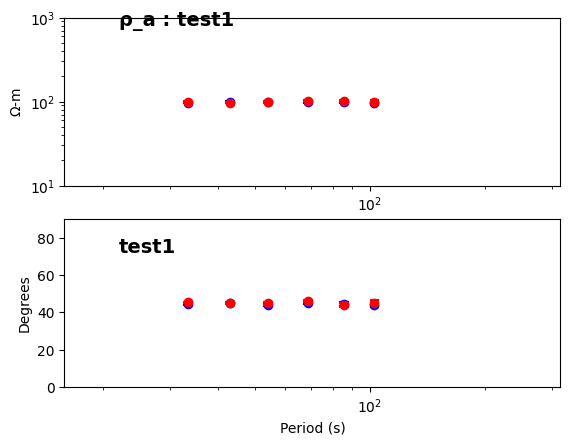

24:10:14T13:36:58 | INFO | line:124 |aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 2
24:10:14T13:36:58 | INFO | line:134 |aurora.pipelines.transfer_function_kernel | update_dataset_df | FC already exists for survey: EMTF Synthetic, station: test1, run: 001 -- skipping decimation
24:10:14T13:36:58 | INFO | line:134 |aurora.pipelines.transfer_function_kernel | update_dataset_df | FC already exists for survey: EMTF Synthetic, station: test2, run: 001 -- skipping decimation
24:10:14T13:36:58 | INFO | line:143 |aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 2 Successfully
24:10:14T13:36:58 | INFO | line:35 |aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Processing band 411.663489s  (0.002429Hz)
24:10:14T13:36:58 | INFO | line:35 |aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Processing band 342.524727s  (0.002919Hz)
24:10:14T13:36:58 | INFO | li

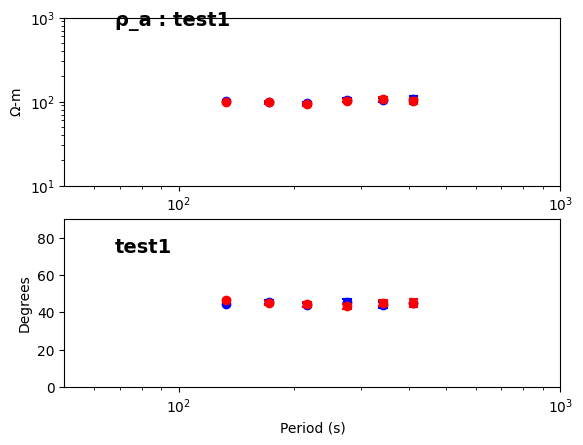

24:10:14T13:36:58 | INFO | line:124 |aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 3
24:10:14T13:36:58 | INFO | line:134 |aurora.pipelines.transfer_function_kernel | update_dataset_df | FC already exists for survey: EMTF Synthetic, station: test1, run: 001 -- skipping decimation
24:10:14T13:36:58 | INFO | line:134 |aurora.pipelines.transfer_function_kernel | update_dataset_df | FC already exists for survey: EMTF Synthetic, station: test2, run: 001 -- skipping decimation
24:10:14T13:36:58 | INFO | line:143 |aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 3 Successfully
24:10:14T13:36:58 | INFO | line:35 |aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Processing band 1514.701336s  (0.000660Hz)
24:10:14T13:36:59 | INFO | line:35 |aurora.time_series.frequency_band_helpers | get_band_for_tf_estimate | Processing band 1042.488956s  (0.000959Hz)
24:10:14T13:36:59 | INFO | 

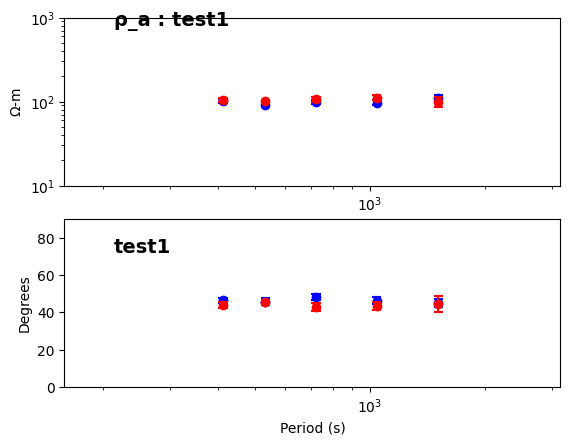

24:10:14T13:36:59 | INFO | line:777 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/software/irismt/mth5/mth5/data/mth5/test12rr.h5
24:10:14T13:36:59 | INFO | line:777 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/software/irismt/mth5/mth5/data/mth5/test12rr.h5


In [9]:
show_plot = True
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                )

### Export TF to a file 

In [10]:
xml_file_base = f"synthetic_test1.xml"
tf_cls.write(fn=xml_file_base, file_type="emtfxml")


EMTFXML(station='test1', latitude=0.00, longitude=0.00, elevation=0.00)

In [11]:
edi_file_base = f"synthetic_test1.edi"
tf_cls.write(fn=edi_file_base, file_type="edi")


Station: test1
--------------------------------------------------
	Survey:        EMTF Synthetic
	Project:       None
	Acquired by:   None
	Acquired date: 1980-01-01
	Latitude:      0.000
	Longitude:     0.000
	Elevation:     0.000
	Impedance:     True
	Tipper:        True
	Number of periods: 25
		Period Range:   4.68249E+00 -- 1.51470E+03 s
		Frequency Range 6.60196E-04 -- 2.13561E-01 s

<div class="alert alert-block alert-info"> <b>NOTE</b> Fourier coefficient section below here is a work in progress. </div>

## Fourier coefficient storage in MTH5

The capability to store Fourier coeffficients (FCs) in MTH5 is now available.  This will enable some different approaches to processing and data quality control (QC).  The data QC tools are a work in progress. The following examples show how to add some FC levels to an MTH5, providing a starting point for processing or feature extraction from these data.

There are currently two main ways to add FCs to the MTH5.

1. Store on the fly while processing with Aurora
2. Use a dedicated method to make FCs only.

### Storing while processing with Aurora

We can store FCs while processing by changing the processing config's `save_fcs` attribute to True 

If we do that with the current processing config however we encouter a warning:

```
Saving FCs for remote reference processing is not supported 
 - To save FCs, process as single station, then you can use the FCs for RR processing 
 - See issue #319 for details  
 - forcing processing config save_fcs = False 
```

There are two workarounds for this:
1. Process each station as a single station, and then the FCs (TODO: Add an example of this)
2. Explicitly call `add_fcs` function.


In [12]:
file_size_before_adding_fcs = mth5_path.stat().st_size
print(f"file_size_before_adding_fcs: {file_size_before_adding_fcs}")

file_size_before_adding_fcs: 6430634


### Using the "single-station processing method" of FC generation

In [13]:
# set  kernel_dataset to work on one station only
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "test1", None)  

# Update the processing config

cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset)

# tell the config to save the FCs
for dec in config.decimations:
    dec.save_fcs = True
    dec.save_fcs_type = "h5"

# you can export the config to a json by uncommenting the following line
# cfg_json = config.to_json()
kernel_dataset.mini_summary

24:10:14T13:37:00 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column fc, adding and setting dtype to <class 'pandas._libs.missing.NAType'>.
24:10:14T13:37:00 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column remote, adding and setting dtype to <class 'bool'>.
24:10:14T13:37:00 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column run_dataarray, adding and setting dtype to <class 'NoneType'>.
24:10:14T13:37:00 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column stft, adding and setting dtype to <class 'NoneType'>.
24:10:14T13:37:00 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column mth5_obj, adding and setting dtype to <class 'NoneType'>.
24:10:14T13:37:00 | INFO | line:108 |aurora.config.config_creator | determine_band_specifica

,survey,station,run,start,end,duration
0,EMTF Synthetic,test1,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00,39999.0


In [14]:
show_plot = False
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                )

24:10:14T13:37:00 | INFO | line:277 |aurora.pipelines.transfer_function_kernel | show_processing_summary | Processing Summary Dataframe:
24:10:14T13:37:00 | INFO | line:278 |aurora.pipelines.transfer_function_kernel | show_processing_summary | 
   duration  has_data  n_samples  run station          survey       run_hdf5_reference   station_hdf5_reference    fc  remote  stft mth5_obj dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0   39999.0      True      40000  001   test1  EMTF Synthetic  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         0         1.0     1.000000            128.0                 128      39999.0             416.0
1   39999.0      True      40000  001   test1  EMTF Synthetic  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         1         4.0     0.250000            512.0                 128       9999.0             103.0
2   39999.0      True  

In [15]:
file_size_after_adding_fcs_station_1 = mth5_path.stat().st_size
print(f"file_size_after_adding_fcs_station_1: {file_size_after_adding_fcs_station_1}")

file_size_after_adding_fcs_station_1: 6430634


In [16]:
# Now the other station

# set  kernel_dataset to work on one station only
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "test2", None)  

# Update the processing config

cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset)

# tell the config to save the FCs
for dec in config.decimations:
    dec.save_fcs = True
    dec.save_fcs_type = "h5"



24:10:14T13:37:02 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column fc, adding and setting dtype to <class 'pandas._libs.missing.NAType'>.
24:10:14T13:37:02 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column remote, adding and setting dtype to <class 'bool'>.
24:10:14T13:37:02 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column run_dataarray, adding and setting dtype to <class 'NoneType'>.
24:10:14T13:37:02 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column stft, adding and setting dtype to <class 'NoneType'>.
24:10:14T13:37:02 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column mth5_obj, adding and setting dtype to <class 'NoneType'>.
24:10:14T13:37:02 | INFO | line:108 |aurora.config.config_creator | determine_band_specifica

In [17]:
show_plot = False
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                )

24:10:14T13:37:02 | INFO | line:277 |aurora.pipelines.transfer_function_kernel | show_processing_summary | Processing Summary Dataframe:
24:10:14T13:37:02 | INFO | line:278 |aurora.pipelines.transfer_function_kernel | show_processing_summary | 
   duration  has_data  n_samples  run station          survey       run_hdf5_reference   station_hdf5_reference    fc  remote  stft mth5_obj dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0   39999.0      True      40000  001   test2  EMTF Synthetic  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         0         1.0     1.000000            128.0                 128      39999.0             416.0
1   39999.0      True      40000  001   test2  EMTF Synthetic  <HDF5 object reference>  <HDF5 object reference>  <NA>   False  None     None         1         4.0     0.250000            512.0                 128       9999.0             103.0
2   39999.0      True  


Now, the FCs are there (for the specific processing configuration).

If you were to re-process the data, the FCs are already there, 

In [18]:
file_size_after_adding_fcs_station_2 = mth5_path.stat().st_size
print(f"file_size_after_adding_fcs_station_2: {file_size_after_adding_fcs_station_2}")

file_size_after_adding_fcs_station_2: 6430634


In [19]:
# set  kernel_dataset to work on both stations again
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "test1", "test2")  

# Update the processing config

cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset)




24:10:14T13:37:05 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column fc, adding and setting dtype to <class 'pandas._libs.missing.NAType'>.
24:10:14T13:37:05 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column remote, adding and setting dtype to <class 'bool'>.
24:10:14T13:37:05 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column run_dataarray, adding and setting dtype to <class 'NoneType'>.
24:10:14T13:37:05 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column stft, adding and setting dtype to <class 'NoneType'>.
24:10:14T13:37:05 | INFO | line:262 |mtpy.processing.kernel_dataset | _add_columns | KernelDataset DataFrame needs column mth5_obj, adding and setting dtype to <class 'NoneType'>.
24:10:14T13:37:05 | INFO | line:108 |aurora.config.config_creator | determine_band_specifica

In [20]:

from aurora.pipelines.transfer_function_kernel import TransferFunctionKernel
tfk = TransferFunctionKernel(dataset=kernel_dataset, config=config)
tfk.make_processing_summary()
tfk.check_if_fcs_already_exist()
tfk.dataset_df

24:10:14T13:37:05 | INFO | line:710 |aurora.pipelines.transfer_function_kernel | mth5_has_fcs | FCs detected -- checking against processing requirements.
24:10:14T13:37:05 | INFO | line:777 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/software/irismt/mth5/mth5/data/mth5/test12rr.h5
24:10:14T13:37:05 | INFO | line:710 |aurora.pipelines.transfer_function_kernel | mth5_has_fcs | FCs detected -- checking against processing requirements.
24:10:14T13:37:05 | INFO | line:777 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/software/irismt/mth5/mth5/data/mth5/test12rr.h5
24:10:14T13:37:05 | INFO | line:248 |aurora.pipelines.transfer_function_kernel | check_if_fcs_already_exist | All fc_levels already existSkip time series processing is OK


,channel_scale_factors,duration,end,has_data,input_channels,mth5_path,n_samples,output_channels,run,sample_rate,start,station,survey,run_hdf5_reference,station_hdf5_reference,fc,remote,run_dataarray,stft,mth5_obj
0,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",39999.0,1980-01-01 11:06:39+00:00,True,"[hx, hy]",/home/kkappler/software/irismt/mth5/mth5/data/...,40000,"[ex, ey, hz]",001,1.0,1980-01-01 00:00:00+00:00,test1,EMTF Synthetic,<HDF5 object reference>,<HDF5 object reference>,True,False,None,None,None
1,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",39999.0,1980-01-01 11:06:39+00:00,True,"[hx, hy]",/home/kkappler/software/irismt/mth5/mth5/data/...,40000,"[ex, ey, hz]",001,1.0,1980-01-01 00:00:00+00:00,test2,EMTF Synthetic,<HDF5 object reference>,<HDF5 object reference>,True,True,None,None,None


In [21]:
show_plot = False
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                )

24:10:14T13:37:05 | INFO | line:277 |aurora.pipelines.transfer_function_kernel | show_processing_summary | Processing Summary Dataframe:
24:10:14T13:37:05 | INFO | line:278 |aurora.pipelines.transfer_function_kernel | show_processing_summary | 
   duration  has_data  n_samples  run station          survey       run_hdf5_reference   station_hdf5_reference    fc  remote  stft mth5_obj dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0   39999.0      True      40000  001   test1  EMTF Synthetic  <HDF5 object reference>  <HDF5 object reference>  True   False  None     None         0         1.0     1.000000            128.0                 128      39999.0             416.0
1   39999.0      True      40000  001   test1  EMTF Synthetic  <HDF5 object reference>  <HDF5 object reference>  True   False  None     None         1         4.0     0.250000            512.0                 128       9999.0             103.0
2   39999.0      True  

###  Using Dedicated FC Generation (`add_fcs` function)

In [22]:
from aurora.pipelines.fourier_coefficients import add_fcs_to_mth5
from aurora.pipelines.fourier_coefficients import fc_decimations_creator
from aurora.pipelines.fourier_coefficients import read_back_fcs

Build a fresh copy of the synthetic data file

In [23]:
mth5_path.unlink()
create_test12rr_h5(target_folder=target_folder)

24:10:14T13:37:08 | INFO | line:685 |mth5.mth5 | _initialize_file | Initialized MTH5 0.1.0 file /home/kkappler/software/irismt/mth5/mth5/data/mth5/test12rr.h5 in mode w
24:10:14T13:37:10 | INFO | line:777 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/software/irismt/mth5/mth5/data/mth5/test12rr.h5


PosixPath('/home/kkappler/software/irismt/mth5/mth5/data/mth5/test12rr.h5')

In this case we need to prescribe the decimation configuration.

If we dont want to decimate, we can just pass 
`fc_decimations == "degenerate"` to add_fcs

Here is how the decimations can be created

In [24]:
sample_rate = 1.0
fc_decimations = fc_decimations_creator(initial_sample_rate=sample_rate, time_period=None)

And here is what they look like, ... a list, with each element specifying the
needed info for decimation and FFT.

In [25]:
fc_decimations


[{
     "decimation": {
         "anti_alias_filter": "default",
         "channels_estimated": [],
         "decimation_factor": 1,
         "decimation_level": 0,
         "harmonic_indices": [
             -1
         ],
         "hdf5_reference": null,
         "id": "0",
         "method": "fft",
         "min_num_stft_windows": 2,
         "mth5_type": null,
         "pre_fft_detrend_type": "linear",
         "prewhitening_type": "first difference",
         "recoloring": true,
         "sample_rate_decimation": 1.0,
         "time_period.end": "1980-01-01T00:00:00+00:00",
         "time_period.start": "1980-01-01T00:00:00+00:00",
         "window.clock_zero_type": "ignore",
         "window.num_samples": 128,
         "window.overlap": 32,
         "window.type": "boxcar"
     }
 },
 {
     "decimation": {
         "anti_alias_filter": "default",
         "channels_estimated": [],
         "decimation_factor": 4,
         "decimation_level": 1,
         "harmonic_indices": [
   

Now add the decimation levels:

In [26]:
add_fcs_to_mth5(mth5_path, fc_decimations=fc_decimations)

24:10:14T13:37:10 | INFO | line:190 |aurora.pipelines.fourier_coefficients | add_fcs_to_mth5 | 


survey: EMTF Synthetic, station: test1, sample_rate 1.0
24:10:14T13:37:10 | INFO | line:207 |aurora.pipelines.fourier_coefficients | add_fcs_to_mth5 | survey: EMTF Synthetic, station: test1, sample_rate 1.0, i_run_row 0
24:10:14T13:37:11 | WARNING | line:292 |mt_metadata.transfer_functions.processing.fourier_coefficients.decimation | is_valid_for_time_series_length | 157 not enough samples for minimum of 2 stft windows of length 128 and overlap 32
24:10:14T13:37:11 | INFO | line:241 |aurora.pipelines.fourier_coefficients | add_fcs_to_mth5 | Decimation Level 4 invalid, TS of 157 samples too short
24:10:14T13:37:11 | WARNING | line:292 |mt_metadata.transfer_functions.processing.fourier_coefficients.decimation | is_valid_for_time_series_length | 40 not enough samples for minimum of 2 stft windows of length 128 and overlap 32
24:10:14T13:37:11 | INFO | line:241 |aurora.pipelines.fourier_coeffi

Now take a look at the mth5

In [27]:
import mth5
m = mth5.mth5.MTH5(mth5_path)
m.open_mth5()

/:
    |- Group: Survey
    ----------------
        |- Group: Filters
        -----------------
            |- Group: coefficient
            ---------------------
                |- Group: 0.1
                -------------
                |- Group: 1
                -----------
                |- Group: 10
                ------------
            |- Group: fap
            -------------
            |- Group: fir
            -------------
            |- Group: time_delay
            --------------------
            |- Group: zpk
            -------------
        |- Group: Reports
        -----------------
        |- Group: Standards
        -------------------
            --> Dataset: summary
            ......................
        |- Group: Stations
        ------------------
            |- Group: test1
            ---------------
                |- Group: 001
                -------------
                    --> Dataset: ex
                    .................
                   

In [28]:
m.close_mth5()


24:10:14T13:37:12 | INFO | line:777 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/software/irismt/mth5/mth5/data/mth5/test12rr.h5


Alternatively, we could have translated the Aurora processing config to an 
mt_metadata FC decimation and gnerated FCs with the same function.

In [29]:
mth5_path.unlink()
create_test12rr_h5(target_folder=target_folder)

24:10:14T13:37:13 | INFO | line:685 |mth5.mth5 | _initialize_file | Initialized MTH5 0.1.0 file /home/kkappler/software/irismt/mth5/mth5/data/mth5/test12rr.h5 in mode w
24:10:14T13:37:14 | INFO | line:777 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/software/irismt/mth5/mth5/data/mth5/test12rr.h5


PosixPath('/home/kkappler/software/irismt/mth5/mth5/data/mth5/test12rr.h5')

In [30]:
# Extract FC decimations from processing config and build the layer

fc_decimations = [
    x.to_fc_decimation() for x in config.decimations
]

add_fcs_to_mth5(mth5_path, fc_decimations=fc_decimations)
            

24:10:14T13:37:14 | INFO | line:190 |aurora.pipelines.fourier_coefficients | add_fcs_to_mth5 | 


survey: EMTF Synthetic, station: test1, sample_rate 1.0
24:10:14T13:37:14 | INFO | line:207 |aurora.pipelines.fourier_coefficients | add_fcs_to_mth5 | survey: EMTF Synthetic, station: test1, sample_rate 1.0, i_run_row 0
24:10:14T13:37:15 | INFO | line:190 |aurora.pipelines.fourier_coefficients | add_fcs_to_mth5 | 


survey: EMTF Synthetic, station: test2, sample_rate 1.0
24:10:14T13:37:15 | INFO | line:207 |aurora.pipelines.fourier_coefficients | add_fcs_to_mth5 | survey: EMTF Synthetic, station: test2, sample_rate 1.0, i_run_row 0
24:10:14T13:37:17 | INFO | line:777 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/software/irismt/mth5/mth5/data/mth5/test12rr.h5


In [31]:

read_back_fcs(mth5_path)

24:10:14T13:37:17 | INFO | line:308 |aurora.pipelines.fourier_coefficients | read_back_fcs | survey: EMTF Synthetic, station: test1, sample_rate 1.0
24:10:14T13:37:17 | INFO | line:311 |aurora.pipelines.fourier_coefficients | read_back_fcs | FC Groups: ['001']
24:10:14T13:37:17 | INFO | line:308 |aurora.pipelines.fourier_coefficients | read_back_fcs | survey: EMTF Synthetic, station: test2, sample_rate 1.0
24:10:14T13:37:17 | INFO | line:311 |aurora.pipelines.fourier_coefficients | read_back_fcs | FC Groups: ['001']
24:10:14T13:37:17 | INFO | line:777 |mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/software/irismt/mth5/mth5/data/mth5/test12rr.h5


And we can see that when processing, aurora detects that the FC layer is already there, and skips creating it.

In [32]:
show_plot = False
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                )

24:10:14T13:37:17 | INFO | line:277 |aurora.pipelines.transfer_function_kernel | show_processing_summary | Processing Summary Dataframe:
24:10:14T13:37:17 | INFO | line:278 |aurora.pipelines.transfer_function_kernel | show_processing_summary | 
   duration  has_data  n_samples  run station          survey       run_hdf5_reference   station_hdf5_reference    fc  remote  stft                                     mth5_obj dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0   39999.0      True      40000  001   test1  EMTF Synthetic  <HDF5 object reference>  <HDF5 object reference>  True   False  None  HDF5 file is closed and cannot be accessed.         0         1.0     1.000000            128.0                 128      39999.0             416.0
1   39999.0      True      40000  001   test1  EMTF Synthetic  <HDF5 object reference>  <HDF5 object reference>  True   False  None  HDF5 file is closed and cannot be accessed.         1         

<div class="alert alert-block alert-info"> <b>NOTE</b> Feature storage section below is a work in progress. </div>


# Feature Storage  **Experimental work in progress**

### Make an example of a feature embedded in mth5 file from the FCs.

Any spectrogram (FC array at some decimation level) can be passed to a feature extraction method.
These features can, in turn be stored in the mth5.

This will have the following steps:

0. select the source FC decimation level (Will use "0" to start, but also test with "1",)

1. Select the frequency bands (probably make these wider than normal so we have plenty of FCs per time window)

- Note these are `feature_extraction_bands`, which are possibly different from TF estimation bands.

To do this we will want to look at the frequencies associated with each FCGroup, and each decimation level.
- Group Runs on Sample Rate
  - tabulate decimation levels
  - group decimation levels by id (and validate that the decimation_level.metadata.sample_rate_decimations agree)
  - for each decimation level, we should get the frequencies associated -- this can be deduced from the shape of the dataset, and
  the min/max frequecies of the metadata, but for now we can just unpack the xarray and take the frequncey axis)

2. loop over the bands (for each band:)

- 2a. extract the band from the FClayer in the mth5 (shape will be nch x ntime x nharmonics)

3. loop over time window (for each time):

- 3a) extract feature

As a placeholder, we will compute the channel crosspowers, and or channel energy.

- 3b) place the feature into an xarray

4) save teh xarray as "feature_cross_power"


In [33]:
# Imports 

from mth5.mth5 import MTH5

import numpy as np
import pandas as pd

In [34]:
# # Selection of frequency bands 

# active_decimation_level = "0"

# m = MTH5(mth5_path)
# m.open_mth5()
# run_summary_df = m.run_summary  # This fails on current main but works on add_aurora_tools branch.
# run_summary_df

It would be nice if we could get a summary of the fcs available in the mth5.  here is a prototype for how that could be done.


In [35]:
# # Prototype for fc_summary

# fc_summary = None

# for i, row in run_summary_df.iterrows():
#     print(row.station, row.run)
#     station_obj = m.get_station(row.station)
#     run_fc_group = station_obj.fourier_coefficients_group.get_fc_group(row.run)
#     if fc_summary is None:
#         fc_summary = run_fc_group.decimation_level_summary
#         fc_summary["station"] = row.station
#         fc_summary["run"] = row.run
#         fc_summary["sample_rate_time_series"] = 0.0
#         fc_summary["window_num_samples"] = 0
#         fc_summary["harmonic_indices"] = None
#     else:
#         tmp = run_fc_group.decimation_level_summary
#         tmp["station"] = row.station
#         tmp["run"] = row.run
#         tmp["sample_rate_time_series"] = 0.0
#         tmp["window_num_samples"] = 0
#         tmp["harmonic_indices"] = None
#         fc_summary = pd.concat([fc_summary, tmp], ignore_index=True)
        
#         #print(run_fc_group)
#     for dec_level_id in run_fc_group.groups_list:
#         dec_level = run_fc_group.get_decimation_level(dec_level_id)
#         cond1 = fc_summary.station==row.station
#         cond2 = fc_summary.run==row.run
#         cond3 = fc_summary.component==dec_level_id
#         fc_summary.loc[cond1 & cond2 & cond3]  # this should be a unique row
#         ndx = fc_summary.loc[cond1 & cond2 & cond3].index
#         assert(len(ndx))==1
#         #fc_summary["sample_rate_time_series"].at[ndx] = dec_level.metadata.i
#         fc_summary["window_num_samples"].at[ndx[0]] = dec_level.metadata.window.num_samples
#         fc_summary["sample_rate_time_series"].at[ndx[0]] = dec_level.metadata.sample_rate
#         fc_summary["harmonic_indices"].at[ndx[0]] = dec_level.metadata.harmonic_indices
        
        
#         #print(dec_level_id, dec_level)
#         xr_dec_level = dec_level.to_xarray()
#         print("station", row.station, "run", row.run, "decimation level", dec_level_id, "SAMPLE rate", dec_level.metadata.sample_rate) # xr_dec_level.frequency)
        

In [36]:
# fc_summary["delta_f"] = fc_summary["sample_rate_time_series"] / fc_summary["window_num_samples"]
# fc_summary

The above table tells us what we need to know to get frequency axes .. and actually, we can make `_frequencies()` a method of `FC_dec_level`.

Note that when harmonic_indices is [-1,], that means all the (1-sided) FCs are kept.
- this can be sanity checked by asserting that the dataset size is `window_num_samples`//2




So now pick a decimation level, ... In this case, the `component` column is telling us the decimation level.
- It would seem sensible to make sure that the sample rates, (and delta_f) values are same as well.



In [37]:
# cond0 = fc_summary["component"] == active_decimation_level
# fc_runs_to_featureize_df = fc_summary[cond0]
# fc_runs_to_featureize_df

In [38]:
# frqs = np.fft.fftfreq?

Now pick a scheme for defining the feature frequency bands
- we prefer not to use the lowest few harmonics ... this is like setting the minimum number of cycles per window, say 10
- we also prefer not to take harmonics very close to the Nyquist frequency as these maybe attenuated by AAF, say we go up to 80% Nyq
- For TF estimation, bands may be only a few FCs wide,but for feature extraction we make them much wider.
- lets try with around half an octave
- how about 2 bands per octave, mean

In [39]:
# min_cycles = 10
# nyquist_fraction = 0.8
# n_feature_bands_per_octave = 2

In [40]:
# for i, row in fc_runs_to_featureize_df.iterrows():
#     frequencies = np.fft.rfftfreq(row.window_num_samples, row.sample_rate_time_series)
#     lower_index = int(min_cycles)
#     upper_index = int(nyquist_fraction*(row.window_num_samples//2))
#     print(f" lower_index={lower_index}, upper_index={upper_index}")
#     freq_min = frequencies[lower_index]
#     freq_max = frequencies[upper_index]
#     print(f"Available band: {freq_min:3f} to {freq_max:3f}")
#     frequency_ratio = freq_max/freq_min
#     available_decades = np.log10(frequency_ratio)
#     available_ocataves = np.log2(frequency_ratio)
#     print(f"Available decades: {available_decades:3f}")
#     print(f"Available octaves: {available_ocataves:3f}")
#     num_feature_bands = available_ocataves * n_feature_bands_per_octave

In [41]:
# dec_level.metadata
# dec_level.to_xarray()

In [42]:
# cond1 = fc_summary.station=="test1"
# cond2 = fc_summary.run=="001"
# cond3 = fc_summary.component=="0"
# fc_summary.loc[cond1 & cond2 & cond3].index

In [43]:
# fc_summary["sample_rate_time_series"].at[0]

In [44]:
# m.close_mth5()